In [195]:
import pandas as pd
import nltk
import matplotlib.pyplot as plt

nltk.download('gutenberg')

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package gutenberg to
[nltk_data]     C:\Users\groov\AppData\Roaming\nltk_data...
[nltk_data]   Package gutenberg is already up-to-date!


In [196]:
def get_alice_df():

    alice = nltk.corpus.gutenberg.raw('carroll-alice.txt')
    alice = alice.replace("\n\n", " ")
    alice = alice.replace("\n", " ")
    alice = alice.replace("[", "")
    alice = alice.replace("]", "")

    sent_text = nltk.sent_tokenize(alice)

    # build initial dataframe
    alice_df = pd.DataFrame(sent_text)
    alice_df.columns = ['sentence']

    # find the chapters, label them, and smash into a single dataframe
    chapters = alice_df[alice_df['sentence'].str.contains('CHAPTER')]

    chapter_dict = {}

    for i in range(1, len(chapters.index)):
        slice_min = chapters.index[i-1]
        slice_max = chapters.index[i]
        df = alice_df[slice_min:slice_max]
        df['chapter'] = i
        chapter_dict[str(i)] = df

    chapter_dict

    df = pd.concat(chapter_dict)
    df.reset_index(inplace=True, drop=True)
    df['sentence'] = df['sentence'] + ' ' # give it space between sentences for the groupby

    return df

In [197]:
alice_df = get_alice_df()
alice_df.head()

,sentence,chapter
0,Alice's Adventures in Wonderland by Lewis Carr...,1
1,Down the Rabbit-Hole Alice was beginning to ge...,1
2,So she was considering in her own mind (as wel...,1
3,There was nothing so VERY remarkable in that; ...,1
4,Oh dear!,1


In [198]:
chapter_df = alice_df.groupby('chapter').sum()
chapter_df

,sentence
chapter,
1,Alice's Adventures in Wonderland by Lewis Carr...
2,* * * * * * * * * ...
3,CHAPTER III. A Caucus-Race and a Long Tale The...
4,CHAPTER IV. The Rabbit Sends in a Little Bill ...
5,CHAPTER V. Advice from a Caterpillar The Cater...
6,CHAPTER VI. Pig and Pepper For a minute or two...
7,CHAPTER VII. A Mad Tea-Party There was a table...
8,CHAPTER VIII. The Queen's Croquet-Ground A lar...
9,CHAPTER IX. The Mock Turtle's Story 'You can't...


In [199]:
from sklearn.feature_extraction.text import TfidfVectorizer

from nltk.tokenize.casual import casual_tokenize

chapters = chapter_df['sentence']

# removing stopwords removes useful information, so don't do it unless you have to
tfidf = TfidfVectorizer(tokenizer=casual_tokenize, ngram_range=(1,3), lowercase=True)
tfidf_docs = tfidf.fit_transform(raw_documents=chapters)

tfidf_docs

<11x39152 sparse matrix of type '<class 'numpy.float64'>'
	with 54544 stored elements in Compressed Sparse Row format>

In [200]:
tfidf_df = pd.DataFrame(tfidf_docs.toarray(), columns=tfidf.get_feature_names(), index=chapter_df.index)
tfidf_df.head(3)

,!,"! ""","! "" ""","! "" '","! "" ?","! "" and","! "" but","! "" here","! "" i","! "" william",...,yourself to say,youth,"youth ,","youth , '",zealand,zealand or,zealand or australia,zigzag,"zigzag ,","zigzag , and"
chapter,,,,,,,,,,,,,,,,,,,,,
1,0.075098,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.007488,0.007488,0.007488,0.0,0.0,0.0
2,0.158806,0.003720,0.0,0.0,0.0,0.0,0.0,0.0,0.007389,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0
3,0.106262,0.003829,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.007607,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0


In [201]:
# you can use this to search for characters

col_df = pd.DataFrame(tfidf_df.columns)
col_df.columns = ['column']
col_df[col_df['column'].str.contains('judge')]

,column
1359,' the judge
8418,be judge
8419,"be judge ,"
17906,i'll be judge
19689,judge
19690,"judge ,"
19691,"judge , '"
19692,"judge , by"
19693,"judge , i'll"
19694,"judge , would"


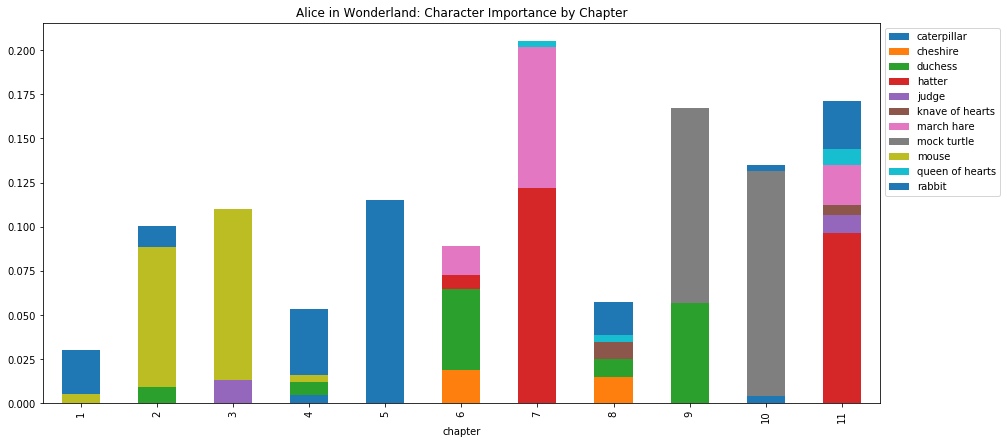

In [202]:
# just pick the damn interesting columns i want...

cols = ['rabbit', 'queen of hearts', 'knave of hearts', 'hatter', 'caterpillar', 'cheshire', 'duchess', 'mouse',
       'mock turtle', 'march hare', 'judge']
cols = sorted(cols)
tfidf_df[cols].plot.bar(figsize=(15,7), stacked=True, title='Alice in Wonderland: Character Importance by Chapter')
_= plt.legend(bbox_to_anchor=(1.0, 1.0), loc='upper left')


In [203]:
# you can use this to read/skim through the book

read_chapter = 1

print(chapter_df.loc[read_chapter]['sentence'])

Alice's Adventures in Wonderland by Lewis Carroll 1865 CHAPTER I. Down the Rabbit-Hole Alice was beginning to get very tired of sitting by her sister on the bank, and of having nothing to do: once or twice she had peeped into the book her sister was reading, but it had no pictures or conversations in it, 'and what is the use of a book,' thought Alice 'without pictures or conversation?' So she was considering in her own mind (as well as she could, for the hot day made her feel very sleepy and stupid), whether the pleasure of making a daisy-chain would be worth the trouble of getting up and picking the daisies, when suddenly a White Rabbit with pink eyes ran close by her. There was nothing so VERY remarkable in that; nor did Alice think it so VERY much out of the way to hear the Rabbit say to itself, 'Oh dear! Oh dear! I shall be late!' (when she thought it over afterwards, it occurred to her that she ought to have wondered at this, but at the time it all seemed quite natural); but when 